# Introduction

GraphCast 最大的数据结构是构建了一个「均匀」的三角形mesh网络, 网络的每个node都可以对应到球面的一个点, 所以可以用$(\theta,\phi)$来简单的表示每个node。
当然在数据结构中，我们直接用 $node_0,node_1,\dots,node_N$ 来顺序存储所有 node
有几个难点:
- 我们需要记录每个 node 的近临关系，在GraphCast中定义了 $M_0,M_1,\dots,M_6$ 七个level，且是5近临或者6近临结构。所以每个level都是应该存储在$(N,6)$的table，每个元素表示的是紧邻的点(由于我们最后是计算综合的aggregate，所以这里的顺序没有关系）
- mesh 的方式是 icosahedral （二十面体）以及后续的三角划分，这种方法叫做 Geodesic_polyhedron [https://en.wikipedia.org/wiki/Geodesic_polyhedron]

所以第一步就是建立球面上的 二十面体 $M_0$ 以及接下来所有 $M_i$ 的 node， 用$(\theta,\phi)$来标记。

- 我们可以用 `anti_lib_progs` 这个包来生成坐标，但是没有临近关系。
- 我们也可以用 Mathematica 13.0 来做
```
GetNearByPoint[polygons_] := Module[{pool = Association[]},
  For[i = 1, i <= Length[polygons], i++,
   polygon = polygons[[i]];
   For[j = 1, j <= 3, j++,
    keyvalue = TakeDrop[polygon, {j}];
    key = keyvalue[[1]][[1]];
    val = keyvalue[[2]];
    If[KeyExistsQ[pool, key], , pool[key] = {}];
    pool[key] = Union[Join[pool[key], val]];
    ]
   ];
  pool
  ]
GetNearByPoint[polygons_, position_] := 
 Module[{pool = Association[]},
  For[i = 1, i <= Length[polygons], i++,
   polygon = polygons[[i]];
   For[j = 1, j <= 3, j++,
    keyvalue = TakeDrop[polygon, {j}];
    key = position[[keyvalue[[1]][[1]]]];
    val = position[[keyvalue[[2]]]];
    If[KeyExistsQ[pool, key], , pool[key] = {}];
    pool[key] = Union[Join[pool[key], val]];
    ]
   ];
  pool
  ]
polygons = GeodesicPolyhedron["Icosahedron", 1];
GetNearByPoint[polygons[[2]], Round[polygons[[1]], 0.0001]]
Graphics3D[polygons]
```
这里我们可以发现， 论文中使用的setting是
`GeodesicPolyhedron["Icosahedron", n];` $n\in[1,2,4,8,16,32,64]$

对应的 node数为 $[12,42,162,642,2562,10242,40962]$

所以还是相当大的一个Mesh, 但他实际上还是取决于分辨率的。
- 比如 32x64 那么对应的 node 为 2048 对于 M5
- 比如 64x128 那么对应的 node 为 8192 对应于 M6
- 比如 720x1440 那么对应的 node 为   这是 25 倍的 M7

### Create Mesh-Node

我们这里直接用 Mathematica 中生成需要的所有 node

In [1]:
import numpy as np
import torch
import csv
import os

In [2]:
flag = "mesh5"

### Mesh Network

In [3]:
import copy

In [4]:
ROOTPATH=f"GraphCastStructure/{flag}"
if not os.path.exists(ROOTPATH):os.makedirs(ROOTPATH)

##### loading

In [8]:
ROOTPATH=f"GraphCastStructure/{flag}"
if not os.path.exists(ROOTPATH):os.makedirs(ROOTPATH)
M2M_node2position                 = np.load(os.path.join(ROOTPATH   ,f"M2M_node2position.npy"   ))
M2M_edgeid2pair                   = np.load(os.path.join(ROOTPATH   ,f"M2M_edgeid2pair.npy"   ))
M2M_position2node                 = torch.load(os.path.join(ROOTPATH,f"M2M_position2node.pt"   )                 )
M2M_node2lined_node               = torch.load(os.path.join(ROOTPATH,f"M2M_node2lined_node.pt"   )               )
M2M_edge2id                       = torch.load(os.path.join(ROOTPATH,f"M2M_edge2id.pt"   )                       )
M2M_nearby_node_per_node_per_level= torch.load(os.path.join(ROOTPATH,f"M2M_nearby_node_per_node_per_level.pt"   ))
M2M_nearby_edge_per_node_per_level= torch.load(os.path.join(ROOTPATH,f"M2M_nearby_edge_per_node_per_level.pt"   ))

In [ ]:
# np.save(os.path.join(ROOTPATH,f"M2M_node2position.npy"   ), node2position)  
# np.save(os.path.join(ROOTPATH,f"M2M_edgeid2pair.npy"   )   , edgeid2pair  )
# torch.save(position2node                ,os.path.join(ROOTPATH,f"M2M_position2node.pt"   )                 )
# torch.save(node_to_linked_nodes         ,os.path.join(ROOTPATH,f"M2M_node2lined_node.pt"   )               )
# torch.save(edge2id                      ,os.path.join(ROOTPATH,f"M2M_edge2id.pt"   )                       )                
# torch.save(node2nearby_por_level        ,os.path.join(ROOTPATH,f"M2M_nearby_node_per_node_per_level.pt"   ))
# torch.save(key_nearbyedge_pair_per_level,os.path.join(ROOTPATH,f"M2M_nearby_edge_per_node_per_level.pt"   ))
# #torch.save(key_nearby_pair_per_level    ,os.path.join(ROOTPATH,f"M2M_pair_per_level.pt"   ))

In [3]:
# node2position                = np.load(f"GraphCastStructure/{flag}_node2position.npy")
# edgeid2pair                  = np.load(f"GraphCastStructure/{flag}_edgeid2pair.npy")
# position2node                = torch.load(f"GraphCastStructure/{flag}_position2node.json.pt")
# key_nearby_pair_per_level    = torch.load(f"GraphCastStructure/{flag}_keynodes2nearbynodes_pair_per_level.json.pt")
# edge2id                      = torch.load(f"GraphCastStructure/{flag}_edge2id.json.pt")
# node2nearby_per_level        = torch.load(f"GraphCastStructure/{flag}_node2nearby_per_level.json.pt")
# key_nearbyedge_pair_per_level= torch.load(f"GraphCastStructure/{flag}_keynodes2nearbyedges_pair_per_level.json.pt")
# node_to_linked_nodes         = torch.load(f"GraphCastStructure/{flag}_node_to_linked_nodes.json.pt")

##### generate 

In [4]:
def readMx(path):
    pool = {}
    with open(path, 'r') as csvfile:
        spamreader = csv.reader(csvfile)
        for row in spamreader:
            key,val = row
            key = eval(key.replace("{","(").replace("}",")"))
            val = eval(val.replace("{","(").replace("}",")"))
            pool[key]=val
    return pool

In [5]:
Mpoolist = [readMx(f'GraphCastStructure/M{i+1}.csv') for i in range(5)]

In [6]:
position2node = {}
for pool in Mpoolist:
    for key in pool:
        if key not in position2node:
            position2node[key] = len(position2node)
node2position = np.zeros((len(position2node),3))
for key,val in position2node.items():
    node2position[val]=np.array(key)
    
torch.save(position2node,os.path.join(ROOTPATH,f"M2M_position2node.pt"   ))
np.save(os.path.join(ROOTPATH,f"M2M_node2position.npy"   ),node2position)  

In [7]:
node2nearby_por_level = []
node_to_linked_nodes ={}
for pool in Mpoolist:
    node2nearby = {}
    linked_nodes = []
    for pos, nearby in pool.items():
        node_id = position2node[pos]
        nearby_ids = [position2node[p] for p in nearby]
        if node_id not in node2nearby:node2nearby[node_id]=[]
        if node_id not in node_to_linked_nodes:node_to_linked_nodes[node_id] = []
        node2nearby[node_id]+=nearby_ids
        node_to_linked_nodes[node_id]+=nearby_ids
    node2nearby_por_level.append(node2nearby)

In [8]:
key_nearby_pair_per_level = []
for level, node2nearby in enumerate(node2nearby_por_level):
    max_length = max([len(t) for t in node2nearby.values()])
    key_nodes = []
    nearby_nodes_list = []
    for key_node,nearby_nodes in node2nearby.items():
        key_nodes.append(key_node)
        nearby_nodes_list.append(nearby_nodes if len(nearby_nodes)==max_length else nearby_nodes+[-1])
    key_nodes = np.array(key_nodes)
    nearby_nodes = np.array(nearby_nodes_list)
    key_nearby_pair_per_level.append([key_nodes,nearby_nodes])
    #print(f"{level}: {min(lenth_list)} - {max(lenth_list)}")

edge2id = {}
for key_nodes, node2nearby in key_nearby_pair_per_level:
    for key_node, nearby_nodes in zip(key_nodes, node2nearby):
        for nearby_node in nearby_nodes:
            if key_node == -1:continue
            if nearby_node == -1:continue
            edge_id = [key_node,nearby_node]
            edge_id.sort()
            edge_id = tuple(edge_id) # unique edge number
            if edge_id not in edge2id:
                edge2id[edge_id] = len(edge2id)
                
edgeid2pair = np.zeros((len(edge2id),2),dtype='int')
for pair, _id in edge2id.items():
    edgeid2pair[_id] = np.array(pair)

key_nearbyedge_pair_per_level = []
for key_nodes, node2nearby in key_nearby_pair_per_level:
    node2nearby_edge_list =[]
    for key_node, nearby_nodes in zip(key_nodes, node2nearby):
        nearby_edge_id = []
        for nearby_node in nearby_nodes:
            if key_node == -1 or nearby_node == -1:
                edge_id = -1
            else:
                edge_pair = [key_node,nearby_node]
                edge_pair.sort()
                edge_id = tuple(edge_pair)
                edge_id = edge2id[edge_id]
            nearby_edge_id.append(edge_id)
        node2nearby_edge_list.append(nearby_edge_id)
    key_nearbyedge_pair_per_level.append([key_nodes,np.array(node2nearby_edge_list)])

In [9]:
np.save(os.path.join(ROOTPATH,f"M2M_edgeid2pair.npy"   ), edgeid2pair)
torch.save(node_to_linked_nodes         ,os.path.join(ROOTPATH,f"M2M_node2lined_node.pt"   ))
torch.save(edge2id                      ,os.path.join(ROOTPATH,f"M2M_edge2id.pt"   ))                
torch.save(node2nearby_por_level        ,os.path.join(ROOTPATH,f"M2M_nearby_node_per_node_per_level.pt"   ))
torch.save(key_nearbyedge_pair_per_level,os.path.join(ROOTPATH,f"M2M_nearby_edge_per_node_per_level.pt"   ))
#torch.save(key_nearby_pair_per_level    ,os.path.join(ROOTPATH,f"M2M_pair_per_level.pt"   ))

In [ ]:
#torch.save(node_to_linked_nodes,os.path.join(ROOTPATH,f"M2M_node2lined_node.pt"   ))

In [116]:
# np.save(f"GraphCastStructure/{flag}_edgeid2pair.npy",edgeid2pair)
# torch.save(edge2id,f"GraphCastStructure/{flag}_edge2id.json.pt")                
# torch.save(key_nearby_pair_per_level,f"GraphCastStructure/{flag}_keynodes2nearbynodes_pair_per_level.json.pt")
# torch.save(node2nearby_por_level,f"GraphCastStructure/{flag}_node2nearby_per_level.json.pt")
# torch.save(key_nearbyedge_pair_per_level,f"GraphCastStructure/{flag}_keynodes2nearbyedges_pair_per_level.json.pt")

### Grid and Mesh Network

然后我们计算 grid 和 node 之间的聚合关系

我们用 721x1440 作为例子, 先用 (720, 1440, 3) 来表示出每个位置的 pos

In [6]:
resolution = 32
resolution_flag=f"{resolution}x{2*resolution}"

In [11]:
ROOTPATH=f"GraphCastStructure/{flag}"
if not os.path.exists(ROOTPATH):os.makedirs(ROOTPATH)
node2position= np.load(os.path.join(ROOTPATH   ,f"M2M_node2position.npy"   ))
position2node= torch.load(os.path.join(ROOTPATH,f"M2M_position2node.pt"   )                 )
ROOTPATH=f"GraphCastStructure/{flag}/{resolution_flag}"
if not os.path.exists(ROOTPATH):os.makedirs(ROOTPATH)

In [7]:
ROOTPATH=f"GraphCastStructure/{flag}/{resolution_flag}"
if not os.path.exists(ROOTPATH):os.makedirs(ROOTPATH)

In [12]:
ROOTPATH

'GraphCastStructure/mesh5/32x64'

#### load

In [5]:
ROOTPATH=f"GraphCastStructure/{flag}/{resolution_flag}"
if not os.path.exists(ROOTPATH):os.makedirs(ROOTPATH)
G2M_grid2LaLotudePos = np.load(os.path.join(ROOTPATH,f"G2M_grid2LaLotudePos.npy"   )     )
M2G_LaLotudePos2grid = np.load(os.path.join(ROOTPATH,f"M2G_LaLotudeGrid2rect_tensor.npy"))
G2M_rect_of_node_tensor    = np.load(os.path.join(ROOTPATH,f"G2M_rect_of_node_tensor.npy"   ) )
G2M_rect_distant_tensor    = np.load(os.path.join(ROOTPATH,f"G2M_rect_distant_tensor.npy"   ) )
G2M_edge_id_of_node_tensor = np.load(os.path.join(ROOTPATH,f"G2M_edge_id_of_node_tensor.npy") )
G2M_edge_coef_node_tensor  = np.load(os.path.join(ROOTPATH,f"G2M_edge_coef_node_tensor.npy" ) )
G2M_edge_id2pair_tensor    = np.load(os.path.join(ROOTPATH,f"G2M_edge_id2pair_tensor.npy"   ) )
G2M_edge_pos2_id           = torch.load(os.path.join(ROOTPATH,f"G2M_edge_pos2_id.pt"   ))
M2G_node_of_rect_tensor    = np.load(os.path.join(ROOTPATH,f"M2G_node_of_rect_tensor.npy"   ))    
M2G_node_distant_tensor    = np.load(os.path.join(ROOTPATH,f"M2G_node_of_rect_tensor.npy"   ))    
M2G_edge_id_of_grid_tensor= np.load(os.path.join(ROOTPATH,f"M2G_edge_id_of_grid_tensor.npy"   ))  
M2G_edge_coef_grid_tensor = np.load(os.path.join(ROOTPATH,f"M2G_edge_coef_grid_tensor.npy"   ) )  
M2G_edge_id2pair_tensor   = np.load(os.path.join(ROOTPATH,f"M2G_edge_id2pair_tensor.npy")      )  
# M2G_node_of_rect        = torch.load(os.path.join(ROOTPATH,f"M2G_node_of_rect.pt"   ))
# M2G_node_distant        = torch.load(os.path.join(ROOTPATH,f"M2G_node_distant.pt"   ))
# M2G_edge_id_of_rect     = torch.load(os.path.join(ROOTPATH,f"M2G_edge_id_of_rect.pt"))
# M2G_edge_coef_rect      = torch.load(os.path.join(ROOTPATH,f"M2G_edge_coef_rect.pt" ))
# M2G_edge_id2pair        = torch.load(os.path.join(ROOTPATH,f"M2G_edge_id2pair.pt"   ))
# M2G_edge_pos2_id        = torch.load(os.path.join(ROOTPATH,f"M2G_edge_pos2_id.pt"   ))

In [8]:
# rect2LaLotude = torch.load(f"GraphCastStructure/{flag}_rect2LaLotude.json.pt")
# LaLotude2rect = torch.load(f"GraphCastStructure/{flag}_LaLotude2rect.json.pt")
# the_neighby_rect_distant = np.load(f"GraphCastStructure/{flag}_the_neighby_rect_distant.npy")
# the_neighby_rect_of_node = np.load(f"GraphCastStructure/{flag}_the_neighby_rect_of_node.npy")
# G2M_edge_id_of_node_tensor = np.load(f"GraphCastStructure/{flag}_G2M_edge_id_of_node_tensor.npy")
# G2M_edge_coef_node_tensor  = np.load(f"GraphCastStructure/{flag}_G2M_edge_coef_node_tensor.npy")
# the_neighby_node_of_rect = torch.load(f"GraphCastStructure/{flag}_the_neighby_node_of_rect.json.pt")
# G2M_edge_id_of_rect_tensor   = np.load(f"GraphCastStructure/{flag}_G2M_edge_id_of_rect_tensor.npy"  )
# G2M_edge_coef_of_rect_tensor = np.load(f"GraphCastStructure/{flag}_G2M_edge_coef_of_rect_tensor.npy")
# LaLotudePos2grid = np.load(f"GraphCastStructure/{flag}_LaLotudePos2grid.npy")

In [ ]:
# M2G_node_of_rect_tensor = np.load(os.path.join(ROOTPATH,f"M2G_node_of_rect_tensor.npy"   ))    
# M2G_node_distant_tensor = np.load(os.path.join(ROOTPATH,f"M2G_node_of_rect_tensor.npy"   ))    
# M2G_node_of_rect        = torch.load(os.path.join(ROOTPATH,f"M2G_node_of_rect.pt"   ))
# M2G_node_distant        = torch.load(os.path.join(ROOTPATH,f"M2G_node_distant.pt"   ))
# M2G_edge_id_of_rect     = torch.load(os.path.join(ROOTPATH,f"M2G_edge_id_of_rect.pt"))
# M2G_edge_coef_rect      = torch.load(os.path.join(ROOTPATH,f"M2G_edge_coef_rect.pt" ))
# M2G_edge_id2pair        = torch.load(os.path.join(ROOTPATH,f"M2G_edge_id2pair.pt"   ))
# M2G_edge_pos2_id        = torch.load(os.path.join(ROOTPATH,f"M2G_edge_pos2_id.pt"   ))

#### generate

In [12]:
theta_offset= (180/resolution/2)
latitude   = (np.linspace(0,180,resolution+1) + theta_offset)[:resolution]
longitude  = np.linspace(0,360,2*resolution+1)[:(2*resolution)]
x, y           = np.meshgrid(latitude, longitude)
LaLotude       = np.stack([y,x],-1).transpose(1,0,2)


pos = node2position
phi         = np.arctan2(pos[:,0],pos[:,1])
phi[phi<0]  = 2*np.pi +  phi[phi<0]
theta       = np.arctan2(np.sqrt(pos[:,0]**2+pos[:,1]**2),pos[:,2]) 
phi   = phi*180/np.pi
theta = theta*180/np.pi

theta_index = (theta-theta_offset)//(180/resolution)
phi_index   = phi//(180/resolution)
rectangle_theta_idx = np.stack([theta_index,theta_index+1,theta_index+1,theta_index],axis=1)

rectangle_phi_idx   = np.stack([phi_index,phi_index,phi_index+1,phi_index+1],axis=1)

rectangle_theta_idx[position2node[0,0, 1]]= np.array([-1,-1,-1,-1])
rectangle_theta_idx[position2node[0,0,-1]]= np.array([resolution,resolution,resolution,resolution])
rectangle_phi_idx[position2node[0,0, 1]]= np.array([0,0,0,0])
rectangle_phi_idx[position2node[0,0,-1]]= np.array([0,0,0,0])

rectangle_theta= rectangle_theta_idx*(180/resolution)+theta_offset
rectangle_theta[rectangle_theta_idx<0]           = 0
rectangle_theta[rectangle_theta_idx>=resolution] = 180

rectangle_phi   = rectangle_phi_idx*(180/resolution)
rectangle_phi[rectangle_phi_idx>=2*resolution] = 0

rectangle_angle_position = np.stack([rectangle_phi,rectangle_theta],-1)

In [648]:
# print(np.sort(np.array(list(set(LaLotude.reshape(-1,2)[:,1])))))
# print(np.sort(np.array(list(set(rectangle_theta.flatten())))))

In [653]:
# print(np.sort(np.array(list(set(LaLotude.reshape(-1,2)[:,0])))))
# print(np.sort(np.array(list(set(rectangle_phi.flatten())))))

In [13]:
rectangle_theta=rectangle_theta/180*np.pi #(720,1440)
rectangle_phi  =rectangle_phi  /180*np.pi #(720,1440) 

rectangle_x = np.sin(rectangle_theta)*np.sin(rectangle_phi)
rectangle_y = np.sin(rectangle_theta)*np.cos(rectangle_phi)
rectangle_z = np.cos(rectangle_theta)
rectangle_position_o = np.stack([rectangle_x,rectangle_y,rectangle_z],-1)

LaLotudePI     = np.stack([y,x],-1).transpose(1,0,2)/180*np.pi #(720,1440)
LaLotudeVector_o = np.stack([np.sin(LaLotudePI[...,1])*np.sin(LaLotudePI[...,0]),
                             np.sin(LaLotudePI[...,1])*np.cos(LaLotudePI[...,0]),
                             np.cos(LaLotudePI[...,1])],2)


In [75]:
# rectangle_position = np.stack([rectangle_x,rectangle_y,rectangle_z],-1)
# rectangle_position[position2node[0,0, 1]]= np.array([[0.        , 0.        , 1.        ]]*4)
# rectangle_position[position2node[0,0,-1]]=np.array([[0.        , 0.        , -1.        ]]*4)

In [14]:
LaLotudeVector     = np.round(LaLotudeVector_o,8)
rectangle_position = np.round(rectangle_position_o,8)
LaLotudeVectorPool = {}
for pos in LaLotudeVector.reshape(-1,3):  
    LaLotudeVectorPool[tuple(pos)] = len(LaLotudeVectorPool)
print(len(LaLotudeVectorPool))
print(len(rectangle_position))

LaLotude2rect = {}
rect2LaLotude = {}
for pos in [(0,0,1),(0,0,-1)]:
    if pos not in LaLotude2rect:
            node = len(LaLotude2rect)
            rect2LaLotude[node]= pos
            LaLotude2rect[pos] = node

for pos_list in rectangle_position:
    for pos in pos_list:
        pos= tuple(pos)
        if pos not in LaLotude2rect:
            node = len(LaLotude2rect)
            rect2LaLotude[node]= pos
            LaLotude2rect[pos] = node
print(len(LaLotude2rect))
G2M_rect_pool = copy.deepcopy(LaLotude2rect)
# now we deal with the rest postion that won't appear in rect
for pos in LaLotudeVectorPool.keys():
    pos= tuple(pos)
    if pos in LaLotude2rect:continue
    node = len(LaLotude2rect)
    rect2LaLotude[node]= pos
    LaLotude2rect[pos] = node

2048
2562
1928


In [15]:
grid2LaLotudePos = []
for i,poss in enumerate(G2M_rect_pool.keys()):
    if (poss[-1]==1) or (poss[-1]==-1):continue
    grid2LaLotudePos.append(LaLotudeVectorPool[tuple(poss)])
G2M_grid2LaLotudePos = np.array(grid2LaLotudePos)  
np.save(os.path.join(ROOTPATH,f"G2M_grid2LaLotudePos.npy"   ),G2M_grid2LaLotudePos)    

In [20]:
# should only be (0,0,1) and (0,0,-1)
for key in LaLotude2rect.keys():
    if key not in LaLotudeVectorPool:
        print(key)

(0, 0, 1)
(0, 0, -1)


In [ ]:
# notice the mesh will not use all grid point 
# in this example, there are 64*128=8192 grid points
# however, the mesh only need 7790 grid poitns
# thus, there are 402 points infomation won't seed to build mesh 
# it is OK for the Grid to Mesh stage.
# but be careful to the procedue during Mesh to Grid stage

In [16]:
# rectangle_position record which grid box the mesh node in.
LaLotudePos2grid = []
for i,poss in enumerate(LaLotudeVector.reshape(-1,3)):
    LaLotudePos2grid.append(LaLotude2rect[tuple(poss)])
LaLotudePos2grid = np.array(LaLotudePos2grid)
LaLotudePos2grid = LaLotudePos2grid.reshape((resolution),(2*resolution))  

np.save(os.path.join(ROOTPATH,f"M2G_LaLotudeGrid2rect_tensor.npy"   ),LaLotudePos2grid)    

In [679]:
#np.save(f"GraphCastStructure/{flag}_LaLotudePos2grid.npy",LaLotudePos2grid)

##### from the Grid to Mesh 

In [17]:
G2M_edge_id2pair   = {} #np.zeros((len(node2position),4),dtype='float')
G2M_edge_pos2_id   = {} #np.zeros((len(node2position),4),dtype='float')

G2M_rect_of_node   = {} #np.zeros((len(node2position),4),dtype='int')
G2M_rect_distant   = {} #np.zeros((len(node2position),4),dtype='float')
G2M_edge_id_of_node= {} #np.zeros((len(node2position),4),dtype='float')
G2M_edge_coef_node = {} #np.zeros((len(node2position),4),dtype='float')

G2M_node_of_rect   = {} #np.zeros((len(node2position),4),dtype='int')
G2M_node_distant   = {} #np.zeros((len(node2position),4),dtype='float')
G2M_edge_id_of_rect= {} #np.zeros((len(node2position),4),dtype='float')
G2M_edge_coef_rect = {} #np.zeros((len(node2position),4),dtype='float')


for node_id, (node_pos,rec_poses) in enumerate(zip(node2position,rectangle_position)):
    for rec_pos in rec_poses:
        rect_id = LaLotude2rect[tuple(rec_pos)]
        distant = np.linalg.norm(node_pos - rec_pos)
        if (rect_id, node_id) not in G2M_edge_pos2_id:
            G2M_edge_id = len(G2M_edge_pos2_id)
            G2M_edge_pos2_id[rect_id, node_id]=G2M_edge_id
            G2M_edge_id2pair[G2M_edge_id] = [rect_id, node_id]
        G2M_edge_id = G2M_edge_pos2_id[rect_id, node_id]
        if node_id not in G2M_edge_id_of_node:G2M_edge_id_of_node[node_id] = [] 
        if node_id not in G2M_edge_coef_node :G2M_edge_coef_node[node_id]  = []
        if node_id not in G2M_rect_of_node   :G2M_rect_of_node[node_id]    = []
        if node_id not in G2M_rect_distant   :G2M_rect_distant[node_id]    = []
        
        if rect_id not in G2M_node_of_rect   :G2M_node_of_rect[rect_id]    = [] 
        if rect_id not in G2M_node_distant   :G2M_node_distant[rect_id]    = []
        if rect_id not in G2M_edge_id_of_rect:G2M_edge_id_of_rect[rect_id] = []
        if rect_id not in G2M_edge_coef_rect :G2M_edge_coef_rect[rect_id]  = []
            
        G2M_rect_of_node[node_id].append(rect_id)
        G2M_rect_distant[node_id].append(distant)
        G2M_edge_id_of_node[node_id].append(G2M_edge_id)
        G2M_edge_coef_node[node_id].append(distant)

        G2M_node_of_rect[rect_id].append(node_id)
        G2M_node_distant[rect_id].append(distant)
        G2M_edge_id_of_rect[rect_id].append(G2M_edge_id)
        G2M_edge_coef_rect[rect_id].append(distant)

In [18]:
# build edge 
G2M_edge_id2pair_tensor   = np.zeros((len(G2M_edge_id2pair),2),dtype='int')  #<-- save 
for i in range(len(G2M_edge_id2pair)):
    G2M_edge_id2pair_tensor[i]    = np.array(G2M_edge_id2pair[i])
G2M_edge_pos2_id = G2M_edge_pos2_id       
np.save(os.path.join(ROOTPATH,f"G2M_edge_id2pair_tensor.npy"   ), G2M_edge_id2pair_tensor) 
torch.save(G2M_edge_pos2_id    ,os.path.join(ROOTPATH,f"G2M_edge_pos2_id.pt"   ))  

In [19]:
# build neighbor rect of ordered node
G2M_rect_of_node_tensor = np.zeros((len(G2M_rect_of_node),4),dtype='int')    #<-- save  
G2M_rect_distant_tensor = np.zeros((len(G2M_rect_of_node),4),dtype='float')  #<-- save 
for i in range(len(G2M_rect_of_node)):
    G2M_rect_of_node_tensor[i] = np.array(G2M_rect_of_node[i])
    G2M_rect_distant_tensor[i] = np.array(G2M_rect_distant[i])
# build neighbor egde of ordered node
G2M_edge_id_of_node_tensor= np.zeros((len(G2M_rect_of_node),4),dtype='int')   #<-- save 
G2M_edge_coef_node_tensor = np.zeros((len(G2M_rect_of_node),4),dtype='float') #<-- save 
for i in range(len(G2M_rect_of_node)):
    G2M_edge_id_of_node_tensor[i] = np.array(G2M_edge_id_of_node[i] )
    G2M_edge_coef_node_tensor[i]  = np.array(G2M_edge_coef_node[i]  )
np.save(os.path.join(ROOTPATH,f"G2M_rect_of_node_tensor.npy"   ), G2M_rect_of_node_tensor)    
np.save(os.path.join(ROOTPATH,f"G2M_rect_distant_tensor.npy"   ), G2M_rect_distant_tensor)    
np.save(os.path.join(ROOTPATH,f"G2M_edge_id_of_node_tensor.npy"), G2M_edge_id_of_node_tensor)    
np.save(os.path.join(ROOTPATH,f"G2M_edge_coef_node_tensor.npy" ), G2M_edge_coef_node_tensor) 
        

In [112]:
# max_rank = 8

# # build neighbor node of ordered rect  (a full grid = rect + ungraded grid)
# G2M_node_of_rect_tensor = np.zeros((len(G2M_node_of_rect),4),dtype='int')    #<-- save  
# G2M_node_distant_tensor = np.zeros((len(G2M_node_of_rect),4),dtype='float')  #<-- save 
# for i in range(len(G2M_node_of_rect)):
#     G2M_node_of_rect_tensor[i] = np.array(G2M_node_of_rect[i])
#     G2M_node_distant_tensor[i] = np.array(G2M_node_distant[i])
# # build neighbor egde of ordered rect
# G2M_edge_id_of_rect_tensor= np.zeros((len(G2M_node_of_rect),4),dtype='int')   #<-- save 
# G2M_edge_coef_rect_tensor = np.zeros((len(G2M_node_of_rect),4),dtype='float') #<-- save 
# for i in range(len(G2M_rect_of_node)):
#     G2M_edge_id_of_rect_tensor[i] = np.array(G2M_edge_id_of_rect[i] )
#     G2M_edge_coef_rect_tensor[i]  = np.array(G2M_edge_coef_rect[i]  )

    


##### from the Mesh to Grid 

###### shared mesh to grid network with rest unused grid

###### a brand new mesh to grid network

In [20]:
M2G_node_of_rect   = {} #np.zeros((len(node2position),4),dtype='int')
M2G_node_distant   = {} #np.zeros((len(node2position),4),dtype='float')
M2G_edge_id2pair   = G2M_edge_id2pair #np.zeros((len(node2position),4),dtype='float')
M2G_edge_pos2_id   = G2M_edge_pos2_id #np.zeros((len(node2position),4),dtype='float')
M2G_edge_id_of_rect= {} #np.zeros((len(node2position),4),dtype='float')
M2G_edge_coef_rect = {} #np.zeros((len(node2position),4),dtype='float')

# firstly we 
for node_id, (node_pos,rec_poses) in enumerate(zip(node2position,rectangle_position)):
    for rec_pos in rec_poses:
        rect_id = LaLotude2rect[tuple(rec_pos)]
        distant = np.linalg.norm(node_pos - rec_pos)
        edgepair= (rect_id,node_id)
        assert edgepair in M2G_edge_pos2_id
#         if  edgepair not in M2G_edge_pos2_id:
#             M2G_edge_id = len(M2G_edge_pos2_id)
#             M2G_edge_pos2_id[edgepair]    = M2G_edge_id
#             M2G_edge_id2pair[M2G_edge_id] = edgepair
        M2G_edge_id = M2G_edge_pos2_id[edgepair]
        if rect_id not in M2G_edge_id_of_rect:M2G_edge_id_of_rect[rect_id] = [] 
        if rect_id not in M2G_edge_coef_rect : M2G_edge_coef_rect[rect_id] = []
        if rect_id not in M2G_node_of_rect   :   M2G_node_of_rect[rect_id] = []
        if rect_id not in M2G_node_distant   :   M2G_node_distant[rect_id] = []
        M2G_node_of_rect[   rect_id].append(node_id)
        M2G_node_distant[   rect_id].append(distant)
        M2G_edge_id_of_rect[rect_id].append(M2G_edge_id)
        M2G_edge_coef_rect[ rect_id].append(distant)
# now we deal with grid that won't appear in rectangle_position:

for pos in LaLotudeVectorPool.keys():
    pos= tuple(pos)
    if pos in LaLotude2rect:continue
    node = len(LaLotude2rect)
    rect2LaLotude[node]= pos
    LaLotude2rect[pos] = node

max_rank = 8
for rec_pos in LaLotudeVectorPool.keys():
    rec_pos    = tuple(rec_pos)
    if rec_pos in G2M_rect_pool:continue
    rect_id    = LaLotude2rect[rec_pos]
    allnodes   = node2position
    alldists   = distant = np.linalg.norm(node2position - np.array([rec_pos]),axis=1)
    near_node  = np.argsort(alldists)[:max_rank]
    near_dist  = alldists[near_node]
    
    for node_id,distant in zip(near_node,near_dist):
        edgepair= (rect_id,node_id)
        if  edgepair not in M2G_edge_pos2_id:
            M2G_edge_id = len(M2G_edge_pos2_id)
            M2G_edge_pos2_id[edgepair]    = M2G_edge_id
            M2G_edge_id2pair[M2G_edge_id] = edgepair
        if rect_id not in M2G_edge_id_of_rect: M2G_edge_id_of_rect[rect_id] = [] 
        if rect_id not in M2G_edge_coef_rect : M2G_edge_coef_rect[rect_id] = []
        if rect_id not in M2G_node_of_rect   :   M2G_node_of_rect[rect_id] = []
        if rect_id not in M2G_node_distant   :   M2G_node_distant[rect_id] = []
        M2G_edge_id = M2G_edge_pos2_id[edgepair]        
        M2G_node_of_rect[   rect_id].append(node_id)
        M2G_node_distant[   rect_id].append(distant)
        M2G_edge_id_of_rect[rect_id].append(M2G_edge_id)
        M2G_edge_coef_rect[ rect_id].append(distant)

In [21]:
M2G_node_of_rect_tensor = np.zeros((len(M2G_node_distant),max_rank),dtype='int')
M2G_node_distant_tensor = np.zeros((len(M2G_node_distant),max_rank),dtype='float')
for rect_id in range(len(M2G_node_distant)):
    nearby_node = M2G_node_of_rect[rect_id]
    nearby_dist = M2G_node_distant[rect_id]
    order       = np.argsort(nearby_dist)[:max_rank]
    nearby_node = [nearby_node[idx] for idx in order]
    nearby_dist = [nearby_dist[idx] for idx in order]
    if len(nearby_node)<max_rank:
        nearby_node = np.pad(nearby_node,(0,max_rank - len(nearby_node)),constant_values=-1)
        nearby_dist = np.pad(nearby_dist,(0,max_rank - len(nearby_dist)),constant_values=-100)
    M2G_node_of_rect_tensor[rect_id]= np.array(nearby_node)
    M2G_node_distant_tensor[rect_id]= np.array(nearby_dist)

In [22]:
np.save(os.path.join(ROOTPATH,f"M2G_node_of_rect_tensor.npy"   ),M2G_node_of_rect_tensor)    
np.save(os.path.join(ROOTPATH,f"M2G_node_distant_tensor.npy"   ),M2G_node_distant_tensor)    

In [23]:
M2G_edge_id2pair_tensor = np.zeros((len(M2G_edge_id2pair),2),dtype='int')   #<-- save 
for i in range(len(M2G_edge_id2pair)):
    M2G_edge_id2pair_tensor[i] = M2G_edge_id2pair[i]

In [24]:
# build neighbor egde of ordered node
M2G_edge_id_of_grid_tensor= np.zeros((len(M2G_node_of_rect),max_rank),dtype='int')   #<-- save 
M2G_edge_coef_grid_tensor = np.zeros((len(M2G_node_of_rect),max_rank),dtype='float') #<-- save 
for rect_id in range(len(M2G_node_distant)):
    nearby_node = M2G_edge_id_of_rect[rect_id]
    nearby_dist =  M2G_edge_coef_rect[rect_id]
    order       = np.argsort(nearby_dist)[:max_rank]
    nearby_node = [nearby_node[idx] for idx in order]
    nearby_dist = [nearby_dist[idx] for idx in order]
    if len(nearby_node)< max_rank:
        nearby_node = np.pad(nearby_node,(0,max_rank - len(nearby_node)),constant_values=-1)
        nearby_dist = np.pad(nearby_dist,(0,max_rank - len(nearby_dist)),constant_values=-100)
    M2G_edge_id_of_grid_tensor[rect_id]= np.array(nearby_node)
    M2G_edge_coef_grid_tensor[rect_id] = np.array(nearby_dist)


In [30]:
ROOTPATH

'GraphCastStructure/mesh5/32x64'

In [25]:
np.save(os.path.join(ROOTPATH,f"M2G_edge_id_of_grid_tensor.npy"   ), M2G_edge_id_of_grid_tensor)    
np.save(os.path.join(ROOTPATH,f"M2G_edge_coef_grid_tensor.npy"   ) , M2G_edge_coef_grid_tensor)    
np.save(os.path.join(ROOTPATH,f"M2G_edge_id2pair_tensor.npy")      , M2G_edge_id2pair_tensor)    

In [ ]:
# torch.save(M2G_node_of_rect    ,os.path.join(ROOTPATH,f"M2G_node_of_rect.pt"   ))    
# torch.save(M2G_node_distant    ,os.path.join(ROOTPATH,f"M2G_node_distant.pt"   ))    
# torch.save(M2G_edge_id_of_rect ,os.path.join(ROOTPATH,f"M2G_edge_id_of_rect.pt"))    
# torch.save(M2G_edge_coef_rect  ,os.path.join(ROOTPATH,f"M2G_edge_coef_rect.pt" )) 
# torch.save(M2G_edge_id2pair    ,os.path.join(ROOTPATH,f"M2G_edge_id2pair.pt"   )) 
# torch.save(M2G_edge_pos2_id    ,os.path.join(ROOTPATH,f"M2G_edge_pos2_id.pt"   ))

In [180]:
# the last thing is get the mapping between (32x64) grid and rect

In [185]:
# the_neighby_node_of_the_rect = []
# the_neighby_node_distantrect = []
# for i in range(len(rect2LaLotude)):
#     the_neighby_node_of_the_rect.append(np.array([key for key,val in the_neighby_node_of_rect[i].items()],dtype='int'))
#     the_neighby_node_distantrect.append(np.array([val for key,val in the_neighby_node_of_rect[i].items()],dtype='float'))
# the_neighby_node_of_the_rect = np.stack(the_neighby_node_of_the_rect)    
# the_neighby_node_distantrect = np.stack(the_neighby_node_distantrect)

# running

#### Grid toMesh

In [ ]:
# G2M_rect_of_node_tensor    
# G2M_rect_distant_tensor    
# G2M_edge_id_of_node_tensor 
# G2M_edge_coef_node_tensor  
# G2M_edge_id2pair_tensor    
# G2M_edge_pos2_id           

In [9]:
G2M_edge_id_of_node_tensor.shape

(10242, 4)

In [10]:
G2M_edge_id_of_node_tensor= torch.LongTensor(G2M_edge_id_of_node_tensor)
G2M_edge_id2pair_tensor   = torch.LongTensor(G2M_edge_id2pair_tensor)
G2M_edge_coef_node_tensor = torch.Tensor(G2M_edge_coef_node_tensor).softmax(-1).unsqueeze(-1)

In [ ]:
B                        = 2 
embedding_dim            = 128
grid_rect_embedding      = torch.randn(B,len(G2M_grid2LaLotudePos),embedding_dim)
north_south_embedding    = torch.randn(B,2,embedding_dim)
grid_rect_embedding      = torch.cat([north_south_embedding,grid_rect_embedding],1)
grid_mesh_bond_embedding = torch.randn(B,len(G2M_edge_id2pair_tensor),embedding_dim)
mesh_node_embedding      = torch.randn(B,len(M2M_node2position),embedding_dim)


MLP_G2M_GM2E= torch.nn.Linear(embedding_dim*3,embedding_dim)
MLP_G2M_E2M = torch.nn.Linear(embedding_dim*2,embedding_dim)
MLP_G2M_G2G = torch.nn.Linear(embedding_dim  ,embedding_dim)


delta_grid_mesh_bond_embedding = MLP_G2M_GM2E(torch.cat([grid_mesh_bond_embedding,
                                 grid_rect_embedding[:,G2M_edge_id2pair_tensor[:,0]],
                                 mesh_node_embedding[:,G2M_edge_id2pair_tensor[:,1]]],-1))

delta_mesh_node_embedding      = MLP_G2M_E2M(torch.cat([mesh_node_embedding,
        torch.mean(delta_grid_mesh_bond_embedding[:,G2M_edge_id_of_node_tensor]*G2M_edge_coef_node_tensor,
                               -2)],-1))

delta_grid_rect_embedding      = MLP_G2M_G2G(grid_rect_embedding)
grid_mesh_bond_embedding+= delta_grid_mesh_bond_embedding
mesh_node_embedding     += delta_mesh_node_embedding
grid_rect_embedding     += delta_grid_rect_embedding

#### Mesh to Mesh

In [ ]:
# M2M_node2position                 
# M2M_edgeid2pair                   
# M2M_position2node                 
# M2M_node2lined_node               
# M2M_edge2id                       
# M2M_nearby_node_per_node_per_level
# M2M_nearby_edge_per_node_per_level

In [ ]:
mesh_mesh_bond_embedding           = torch.randn(B,len(M2M_edgeid2pair),embedding_dim)

In [78]:
MLP_M2M_N2E = torch.nn.Linear(128*3,128)
MLP_M2M_E2N = torch.nn.Linear(128*2,128)

In [79]:
delta_mesh_mesh_bond_embedding = MLP_M2M_N2E(torch.cat([mesh_mesh_bond_embedding,
                                                        mesh_node_embedding[:,M2M_edgeid2pair[:,0]],
                                                        mesh_node_embedding[:,M2M_edgeid2pair[:,1]]],-1))

In [80]:
delta_mesh_mesh_bond_embedding.shape

torch.Size([2, 40950, 128])

In [81]:
delta_mesh_mesh_bond_embedding= torch.nn.functional.pad(delta_mesh_mesh_bond_embedding,(0,0,0,1))
# notice the nearby node of each level either 5 or 6, then we use -1 as the padding number.
mesh_node_aggregration = torch.zeros_like(mesh_node_embedding)
for start_node, end_node_list in key_nearbyedge_pair_per_level:
    mesh_node_aggregration[:,start_node] += delta_mesh_mesh_bond_embedding[:,end_node_list].sum(-2)
mesh_node_aggregration = mesh_node_aggregration/num_of_linked_nodes.unsqueeze(-1)
delta_mesh_node_embedding = MLP_G2M_E2M(torch.cat([mesh_node_embedding,mesh_node_aggregration],-1))

mesh_mesh_bond_embedding += delta_mesh_mesh_bond_embedding[:,:-1]
mesh_node_embedding      += delta_mesh_node_embedding

#### Mesh to Grid

In [40]:
len(M2G_edge_id_of_grid_tensor)

2050

In [41]:
G2M_grid2LaLotudePos.shape

(2042,)

In [13]:
# M2G_node_of_rect_tensor    
# M2G_node_distant_tensor  
# M2G_edge_id_of_grid_tensor
# M2G_edge_coef_grid_tensor
# M2G_edge_id2pair_tensor

(10242, 4)

In [216]:
# G2M_edge_id_of_rect_tensor   = np.load(f"GraphCastStructure/{flag}_G2M_edge_id_of_rect_tensor.npy"  )
# G2M_edge_coef_of_rect_tensor = np.load(f"GraphCastStructure/{flag}_G2M_edge_coef_of_rect_tensor.npy")

In [122]:
MLP_M2G_MG2E= torch.nn.Linear(128*3,128)
MLP_M2G_E2G = torch.nn.Linear(128*2,128)

In [ ]:
mesh_grid_bond_embedding = torch.nn.functional.pad(grid_mesh_bond_embedding,(0,0,0,len(M2G_edge_id2pair_tensor) - len(G2M_edge_id2pair_tensor) ))
grid_allrect_embedding   = torch.nn.functional.pad(grid_rect_embedding,(0,0,0,len(M2G_node_of_rect_tensor) - grid_rect_embedding.shape[-2] ))

In [38]:
M2G_edge_id2pair_tensor[:,0].max()

2049

In [34]:
M2G_edge_id2pair_tensor.max()

10241

# Test

In [169]:
class MLP(nn.Module):
    def __init__(self, input_channel, output_cannel, bias=False, 
                 nonlinear='tanh',depth=1):
        super().__init__()
        self.linear    = torch.nn.Linear(input_channel,output_cannel,bias=bias)
        self.nonlinear = nonlinear
        self.depth     = depth
        if nonlinear == 'tanh':
            self.activator = torch.nn.Tanh()
        elif nonlinear == 'relu':
            self.activator = torch.nn.ReLU()
        elif nonlinear == 'sigmoid':
            self.activator = torch.nn.Sigmoid()
        else:
            raise NotImplementedError
    def forward(self,x):
        for _ in range(self.depth):
            x = self.activator(self.linear(x))
        return x

In [170]:
class Grid2Mesh(nn.Module):
    def __init__(self, G2M_edge_id2pair_tensor, G2M_edge_id_of_node_tensor, G2M_edge_coef_node_tensor, 
                 embed_dim=128,nonlinear='tanh',mlp_depth=1,mlp_bias = False):
        super().__init__()
        self.G2M_edge_id2pair_tensor   = G2M_edge_id2pair_tensor
        self.G2M_edge_id_of_node_tensor= G2M_edge_id_of_node_tensor
        self.G2M_edge_coef_node_tensor = G2M_edge_coef_node_tensor
        self.MLP_G2M_GM2E= MLP(embed_dim*3,embed_dim,nonlinear=nonlinear,depth=mlp_depth,bias=mlp_bias)
        self.MLP_G2M_E2M = MLP(embed_dim*2,embed_dim,nonlinear=nonlinear,depth=mlp_depth,bias=mlp_bias)
        self.MLP_G2M_G2G = MLP(embed_dim  ,embed_dim,nonlinear=nonlinear,depth=mlp_depth,bias=mlp_bias)
        self.rect_index_limit = self.G2M_edge_id2pair_tensor[:,0].max() + 1
        self.node_index_limit = self.G2M_edge_id2pair_tensor[:,1].max() + 1
        self.edge_index_limit = len(self.G2M_edge_id2pair_tensor)
    def forward(self, grid_mesh_bond_embedding,grid_rect_embedding,mesh_node_embedding):
        ### shape checking
        ### all the necessary rect of grid is recorded in G2M_grid2LaLotudePos
        #### we will plus north south point at the begining torch.cat([north_south_embedding,grid_rect_embedding],1)
        assert len(grid_rect_embedding.shape) == len(mesh_node_embedding.shape) == len(grid_mesh_bond_embedding.shape) == 3
        assert self.rect_index_limit == grid_rect_embedding.shape[1]
        assert self.node_index_limit == mesh_node_embedding.shape[1]
        assert self.edge_index_limit == grid_mesh_bond_embedding.shape[1] 
        delta_grid_mesh_bond_embedding = self.MLP_G2M_GM2E(torch.cat([grid_mesh_bond_embedding,
                                 grid_rect_embedding[:,self.G2M_edge_id2pair_tensor[:,0]],
                                 mesh_node_embedding[:,self.G2M_edge_id2pair_tensor[:,1]]],-1))

        delta_mesh_node_embedding      = self.MLP_G2M_E2M(torch.cat([mesh_node_embedding,
                torch.mean(delta_grid_mesh_bond_embedding[:,self.G2M_edge_id_of_node_tensor]*self.G2M_edge_coef_node_tensor,
                                       -2)],-1))
        delta_grid_rect_embedding      = self.MLP_G2M_G2G(grid_rect_embedding)
        grid_mesh_bond_embedding      += delta_grid_mesh_bond_embedding
        grid_rect_embedding           += delta_grid_rect_embedding
        mesh_node_embedding           += delta_mesh_node_embedding
        return grid_mesh_bond_embedding,grid_rect_embedding,mesh_node_embedding

class Mesh2Grid(nn.Module):
    def __init__(self, M2G_edge_id2pair_tensor, M2G_edge_id_of_grid_tensor, M2G_edge_coef_grid_tensor, \
                 embed_dim=128,nonlinear='tanh',mlp_depth=1,mlp_bias = False):
        super().__init__()
        self.M2G_edge_id2pair_tensor      = M2G_edge_id2pair_tensor
        self.M2G_edge_id_of_grid_tensor   = M2G_edge_id_of_grid_tensor
        self.M2G_edge_coef_grid_tensor = M2G_edge_coef_grid_tensor
        
        self.MLP_M2G_MG2E= MLP(embed_dim*3,embed_dim,nonlinear=nonlinear,depth=mlp_depth,bias=mlp_bias)
        self.MLP_M2G_E2G = MLP(embed_dim*2,embed_dim,nonlinear=nonlinear,depth=mlp_depth,bias=mlp_bias)

        self.rect_index_limit = self.M2G_edge_id2pair_tensor[:,0].max() + 1
        self.node_index_limit = self.M2G_edge_id2pair_tensor[:,1].max() + 1
        self.edge_index_limit = len(self.M2G_edge_id2pair_tensor)

    def forward(self, mesh_grid_bond_embedding,grid_allrect_embedding,mesh_node_embedding):
        assert len(grid_allrect_embedding.shape) == len(mesh_node_embedding.shape) == len(mesh_grid_bond_embedding.shape) == 3
        assert self.rect_index_limit == grid_allrect_embedding.shape[1]
        assert self.node_index_limit == mesh_node_embedding.shape[1]
        assert self.edge_index_limit == mesh_grid_bond_embedding.shape[1] 
        
        delta_mesh_grid_bond_embedding = self.MLP_M2G_MG2E(torch.cat([mesh_grid_bond_embedding,
                                      mesh_node_embedding[:,self.M2G_edge_id2pair_tensor[:,1]],
                                   grid_allrect_embedding[:,self.M2G_edge_id2pair_tensor[:,0]]],-1))
        delta_grid_rect_embedding     = self.MLP_M2G_E2G(torch.cat([grid_allrect_embedding,
                            torch.mean(delta_mesh_grid_bond_embedding[:,self.M2G_edge_id_of_grid_tensor]*self.M2G_edge_coef_grid_tensor,
                                       -2)],-1))
        grid_allrect_embedding += delta_grid_rect_embedding
        return grid_allrect_embedding

class Mesh2Mesh(nn.Module):
    def __init__(self, M2M_edgeid2pair, key_nearbyedge_pair_per_level, num_of_linked_nodes, 
                 embed_dim=128,nonlinear='tanh',mlp_depth=1,mlp_bias = False):
        super().__init__()
        self.M2M_edgeid2pair = M2M_edgeid2pair
        self.key_nearbyedge_pair_per_level = key_nearbyedge_pair_per_level
        self.num_of_linked_nodes = num_of_linked_nodes
        
        self.MLP_M2M_N2E= MLP(embed_dim*3,embed_dim,nonlinear=nonlinear,depth=mlp_depth,bias=mlp_bias)
        self.MLP_M2M_E2N= MLP(embed_dim*2,embed_dim,nonlinear=nonlinear,depth=mlp_depth,bias=mlp_bias)

        self.node_index_limit = self.M2M_edgeid2pair[:,1].max() + 1
        self.edge_index_limit = len(self.M2M_edgeid2pair)
        
    def forward(self, mesh_mesh_bond_embedding,mesh_node_embedding):
        assert len(mesh_node_embedding.shape) == len(grid_mesh_bond_embedding.shape) == 3
        assert self.node_index_limit == mesh_node_embedding.shape[1]
        assert self.edge_index_limit == mesh_mesh_bond_embedding.shape[1] 
        delta_mesh_mesh_bond_embedding = self.MLP_M2M_N2E(torch.cat([mesh_mesh_bond_embedding,
                                        mesh_node_embedding[:,self.M2M_edgeid2pair[:,0]],
                                        mesh_node_embedding[:,self.M2M_edgeid2pair[:,1]]],-1))
        delta_mesh_mesh_bond_embedding= torch.nn.functional.pad(delta_mesh_mesh_bond_embedding,(0,0,0,1))
        # notice the nearby node of each level either 5 or 6, then we use -1 as the padding number.
        mesh_node_aggregration = torch.zeros_like(mesh_node_embedding)
        for start_node, end_node_list in self.key_nearbyedge_pair_per_level:
            mesh_node_aggregration[:,start_node] += delta_mesh_mesh_bond_embedding[:,end_node_list].sum(-2)
        mesh_node_aggregration = mesh_node_aggregration/self.num_of_linked_nodes
        
        delta_mesh_node_embedding = self.MLP_M2M_E2N(torch.cat([mesh_node_embedding,mesh_node_aggregration],-1))
        mesh_mesh_bond_embedding += delta_mesh_mesh_bond_embedding[:,:-1]
        mesh_node_embedding      += delta_mesh_node_embedding    
        return mesh_mesh_bond_embedding,mesh_node_embedding

In [ ]:
ROOTPATH=f"GraphCastStructure/{flag}"
if not os.path.exists(ROOTPATH):os.makedirs(ROOTPATH)
M2M_node2position                 = np.load(os.path.join(ROOTPATH   ,f"M2M_node2position.npy"   ))
M2M_position2node                 = torch.load(os.path.join(ROOTPATH,f"M2M_position2node.pt"   )                 )
# M2M_node2lined_node               = torch.load(os.path.join(ROOTPATH,f"M2M_node2lined_node.pt"   )               )
# M2M_edge2id                       = torch.load(os.path.join(ROOTPATH,f"M2M_edge2id.pt"   )                       )

M2M_edgeid2pair                   = np.load(os.path.join(ROOTPATH   ,f"M2M_edgeid2pair.npy"   ))
M2M_nearby_edge_per_node_per_level= torch.load(os.path.join(ROOTPATH,f"M2M_nearby_edge_per_node_per_level.pt"   ))
#M2M_nearby_node_per_node_per_level= torch.load(os.path.join(ROOTPATH,f"M2M_nearby_node_per_node_per_level.pt"   ))

ROOTPATH=f"GraphCastStructure/{flag}/{resolution_flag}"
if not os.path.exists(ROOTPATH):os.makedirs(ROOTPATH)
G2M_grid2LaLotudePos = np.load(os.path.join(ROOTPATH,f"G2M_grid2LaLotudePos.npy"   )     )
M2G_LaLotudePos2grid = np.load(os.path.join(ROOTPATH,f"M2G_LaLotudeGrid2rect_tensor.npy"))

# G2M_rect_of_node_tensor    = np.load(os.path.join(ROOTPATH,f"G2M_rect_of_node_tensor.npy"   ) )
# G2M_rect_distant_tensor    = np.load(os.path.join(ROOTPATH,f"G2M_rect_distant_tensor.npy"   ) )
G2M_edge_id_of_node_tensor = np.load(os.path.join(ROOTPATH,f"G2M_edge_id_of_node_tensor.npy") )
G2M_edge_coef_node_tensor  = np.load(os.path.join(ROOTPATH,f"G2M_edge_coef_node_tensor.npy" ) )
G2M_edge_id2pair_tensor    = np.load(os.path.join(ROOTPATH,f"G2M_edge_id2pair_tensor.npy"   ) )
# G2M_edge_pos2_id           = torch.load(os.path.join(ROOTPATH,f"G2M_edge_pos2_id.pt"   ))
# M2G_node_of_rect_tensor    = np.load(os.path.join(ROOTPATH,f"M2G_node_of_rect_tensor.npy"   ))    
# M2G_node_distant_tensor    = np.load(os.path.join(ROOTPATH,f"M2G_node_of_rect_tensor.npy"   ))    
M2G_edge_id_of_grid_tensor= np.load(os.path.join(ROOTPATH,f"M2G_edge_id_of_grid_tensor.npy"   ))  
M2G_edge_coef_grid_tensor = np.load(os.path.join(ROOTPATH,f"M2G_edge_coef_grid_tensor.npy"   ) )  
M2G_edge_id2pair_tensor   = np.load(os.path.join(ROOTPATH,f"M2G_edge_id2pair_tensor.npy")      )  

In [78]:
B                        = 2 
grid_rect_embedding      = torch.randn(B,len(G2M_grid2LaLotudePos),embedding_dim)
north_south_embedding    = torch.randn(B,2,embedding_dim)
grid_rect_embedding      = torch.cat([north_south_embedding,grid_rect_embedding],1)
grid_mesh_bond_embedding = torch.randn(B,len(G2M_edge_id2pair_tensor),embedding_dim)
mesh_node_embedding      = torch.randn(B,len(M2M_node2position),embedding_dim)
mesh_mesh_bond_embedding = torch.randn(B,len(M2M_edgeid2pair),embedding_dim)

In [97]:
embedding_layer = nn.Linear(70,embedding_dim)
_input = torch.randn(B,70,64,128)

In [101]:
feature_along_latlot = embedding_layer(_input.permute(0,2,3,1).flatten(1,2))
grid_rect_embedding  = feature_along_latlot[:,G2M_grid2LaLotudePos]
north_south_embedding= torch.randn(B,2,embedding_dim)
grid_rect_embedding  = torch.cat([north_south_embedding,grid_rect_embedding],1)

In [84]:

grid_mesh_bond_embedding,grid_rect_embedding,mesh_node_embedding = layer_grid2mesh(grid_mesh_bond_embedding,grid_rect_embedding,mesh_node_embedding)
mesh_mesh_bond_embedding, mesh_node_embedding  = layer_mesh2mesh(mesh_mesh_bond_embedding, mesh_node_embedding)

mesh_grid_bond_embedding = torch.nn.functional.pad(grid_mesh_bond_embedding,(0,0,0,len(M2G_edge_id2pair_tensor) - len(G2M_edge_id2pair_tensor) ))
grid_allrect_embedding   = torch.nn.functional.pad(grid_rect_embedding,(0,0,0,len(M2G_node_of_rect_tensor) - grid_rect_embedding.shape[-2] ))
grid_allrect_embedding   = layer_mesh2grid(mesh_grid_bond_embedding,grid_allrect_embedding,mesh_node_embedding)

In [102]:
.shape

torch.Size([2, 64, 128, 128])

In [254]:
import torch.nn as nn

In [ ]:
flag = "mesh6"

In [182]:
class GraphCast(nn.Module):
    '''
    Repreduce of GraphCast in Pytorch.
    GraphCast has three part:
    - Grid to Mesh
    - Mesh to Mesh
    - Mesh to Grid
    -------------------------------------
    the input is a tensor (B, P, W, H), but the internal tensor all with shape (B, L ,P)
    where the L equal the node number or edge number.
    '''
    def __init__(self, img_size=(64,128),  in_chans=70, out_chans=70, depth=6, embed_dim=128, flag='mesh6'):
        super().__init__()
        resolution_flag=f'{img_size[0]}x{img_size[1]}'
        ROOTPATH=f"GraphCastStructure/{flag}"
        if not os.path.exists(ROOTPATH):os.makedirs(ROOTPATH)
        M2M_node2position                 = np.load(os.path.join(ROOTPATH   ,f"M2M_node2position.npy"   ))
        M2M_position2node                 = torch.load(os.path.join(ROOTPATH,f"M2M_position2node.pt"   )                 )
        # M2M_node2lined_node               = torch.load(os.path.join(ROOTPATH,f"M2M_node2lined_node.pt"   )               )
        # M2M_edge2id                       = torch.load(os.path.join(ROOTPATH,f"M2M_edge2id.pt"   )                       )

        M2M_edgeid2pair                   = np.load(os.path.join(ROOTPATH   ,f"M2M_edgeid2pair.npy"   ))
        M2M_nearby_edge_per_node_per_level= torch.load(os.path.join(ROOTPATH,f"M2M_nearby_edge_per_node_per_level.pt"   ))
        #M2M_nearby_node_per_node_per_level= torch.load(os.path.join(ROOTPATH,f"M2M_nearby_node_per_node_per_level.pt"   ))

        ROOTPATH=f"GraphCastStructure/{flag}/{resolution_flag}"
        if not os.path.exists(ROOTPATH):os.makedirs(ROOTPATH)
        G2M_grid2LaLotudePos = np.load(os.path.join(ROOTPATH,f"G2M_grid2LaLotudePos.npy"   )     )
        M2G_LaLotudePos2grid = np.load(os.path.join(ROOTPATH,f"M2G_LaLotudeGrid2rect_tensor.npy"))

        # G2M_rect_of_node_tensor    = np.load(os.path.join(ROOTPATH,f"G2M_rect_of_node_tensor.npy"   ) )
        # G2M_rect_distant_tensor    = np.load(os.path.join(ROOTPATH,f"G2M_rect_distant_tensor.npy"   ) )
        G2M_edge_id_of_node_tensor = np.load(os.path.join(ROOTPATH,f"G2M_edge_id_of_node_tensor.npy") )
        G2M_edge_coef_node_tensor  = np.load(os.path.join(ROOTPATH,f"G2M_edge_coef_node_tensor.npy" ) )
        G2M_edge_id2pair_tensor    = np.load(os.path.join(ROOTPATH,f"G2M_edge_id2pair_tensor.npy"   ) )
        # G2M_edge_pos2_id           = torch.load(os.path.join(ROOTPATH,f"G2M_edge_pos2_id.pt"   ))
        # M2G_node_of_rect_tensor    = np.load(os.path.join(ROOTPATH,f"M2G_node_of_rect_tensor.npy"   ))    
        # M2G_node_distant_tensor    = np.load(os.path.join(ROOTPATH,f"M2G_node_of_rect_tensor.npy"   ))    
        M2G_edge_id_of_grid_tensor= np.load(os.path.join(ROOTPATH,f"M2G_edge_id_of_grid_tensor.npy"   ))  
        M2G_edge_coef_grid_tensor = np.load(os.path.join(ROOTPATH,f"M2G_edge_coef_grid_tensor.npy"   ) )  
        M2G_edge_id2pair_tensor   = np.load(os.path.join(ROOTPATH,f"M2G_edge_id2pair_tensor.npy")      )  
        
        embedding_dim = embed_dim
        self.num_unactivated_grid = num_unactivated_grid = len(M2G_edge_id_of_grid_tensor) - grid_rect_embedding.shape[1]
        self.num_unactivated_edge = num_unactivated_edge = len(M2G_edge_id2pair_tensor) - len(G2M_edge_id2pair_tensor)
        print(f'''
        This is ===> GraphCast Model <===
        Information: 
            total mesh node:{len(M2M_node2position):5d} total unique mesh edge:{len(M2M_edgeid2pair):5d} 
            total grid node {np.prod(img_size)}+2 = {(len(M2G_edge_id_of_grid_tensor))} but activated grid {len(G2M_grid2LaLotudePos):5d} +  2
            from activated grid to mesh, create 4*{len(M2M_node2position)} = {len(G2M_edge_id2pair_tensor)} edge
            there are {num_unactivated_grid} unactivated grid node
            when mapping node to grid, 
            from node to activated grid, there are {len(G2M_edge_id2pair_tensor)} 
            from node to unactivated grid, there are {num_unactivated_edge} edge
            thus, totally have {len(M2G_edge_id2pair_tensor)} edge. 
            #notice some grid only have 1-2 linked node but some grid may have 30 lined node
        ''')
        G2M_edge_id2pair_tensor   = torch.LongTensor(G2M_edge_id2pair_tensor)
        G2M_edge_coef_node_tensor = torch.Tensor(G2M_edge_coef_node_tensor).softmax(-1).unsqueeze(-1)
        
        M2M_edgeid2pair                    = torch.LongTensor(M2M_edgeid2pair)
        M2M_nearby_edge_per_node_per_level = [[torch.LongTensor(start_node),torch.LongTensor(linked_edge_list)] for start_node,linked_edge_list in M2M_nearby_edge_per_node_per_level]
        M2M_num_of_linked_nodes            = torch.FloatTensor([len(M2M_node2lined_node[t]) for t in range(len(M2M_node2lined_node))]).unsqueeze(-1)
        
        M2G_edge_id2pair_tensor  = torch.LongTensor(M2G_edge_id2pair_tensor)
        M2G_node_of_rect_tensor  = torch.LongTensor(M2G_edge_id_of_grid_tensor)
        
        M2G_edge_coef_grid_tensor= torch.Tensor(M2G_edge_coef_grid_tensor).softmax(-1).unsqueeze(-1)

        M2G_LaLotudePos2grid = torch.LongTensor(M2G_LaLotudePos2grid)
        G2M_grid2LaLotudePos = torch.LongTensor(G2M_grid2LaLotudePos)
        
        self.M2G_LaLotudePos2grid = M2G_LaLotudePos2grid
        self.G2M_grid2LaLotudePos = G2M_grid2LaLotudePos
        
        self.layer_grid2mesh = Grid2Mesh(G2M_edge_id2pair_tensor,G2M_edge_id_of_node_tensor,
                                         G2M_edge_coef_node_tensor, embed_dim=128)
        
        self.layer_mesh2mesh = nn.ModuleList()
        for i in range(depth):
            self.layer_mesh2mesh.append(Mesh2Mesh(M2M_edgeid2pair, 
                                                  M2M_nearby_edge_per_node_per_level, 
                                                  M2M_num_of_linked_nodes, embed_dim=embedding_dim))
        self.layer_mesh2grid = Mesh2Grid(M2G_edge_id2pair_tensor,M2G_node_of_rect_tensor,M2G_edge_coef_grid_tensor)
        self.grid_rect_embedding_layer = nn.Linear(in_chans,embedding_dim)

        
        self.northsouthembbed = nn.Parameter(torch.randn(2,embedding_dim))
        
        self.mesh_node_embedding       = nn.Parameter(torch.randn(len(M2M_node2position),embedding_dim))
        self.mesh_mesh_bond_embedding  = nn.Parameter(torch.randn(len(M2M_edgeid2pair),embedding_dim))
        self.grid_mesh_bond_embedding  = nn.Parameter(torch.randn(len(G2M_edge_id2pair_tensor),embedding_dim))

        self.projection      = nn.Linear(embedding_dim,out_chans)
    def forward(self, _input):
        B, P , W, H =_input.shape
        feature_along_latlot     = embedding_layer(_input.permute(0,2,3,1).flatten(1,2))
        grid_rect_embedding      = feature_along_latlot[:,self.G2M_grid2LaLotudePos]
        grid_rect_embedding      = torch.cat([self.northsouthembbed.repeat(B,1,1),grid_rect_embedding],1)
        grid_mesh_bond_embedding = self.grid_mesh_bond_embedding.repeat(B,1,1)
        mesh_node_embedding      = self.mesh_node_embedding.repeat(B,1,1)
        mesh_mesh_bond_embedding = self.mesh_mesh_bond_embedding.repeat(B,1,1)
        grid_mesh_bond_embedding,grid_rect_embedding,mesh_node_embedding = self.layer_grid2mesh(
                                        grid_mesh_bond_embedding,grid_rect_embedding,mesh_node_embedding)
        for mesh2mesh in self.layer_mesh2mesh:
            mesh_mesh_bond_embedding, mesh_node_embedding  = mesh2mesh(mesh_mesh_bond_embedding, 
                                                                       mesh_node_embedding)
        grid_mesh_bond_embedding = torch.nn.functional.pad(grid_mesh_bond_embedding,(0,0,0,self.num_unactivated_edge))
        grid_rect_embedding      = torch.nn.functional.pad(grid_rect_embedding,(0,0,0,self.num_unactivated_grid ))
        grid_rect_embedding      = layer_mesh2grid(grid_mesh_bond_embedding,grid_rect_embedding,mesh_node_embedding)
        grid_rect_embedding      = grid_rect_embedding[:,self.M2G_LaLotudePos2grid] #(B,64,128,embed_dim)
        return self.projection(grid_rect_embedding).permute(0,3,1,2)


In [124]:
len(M2G_edge_id_of_grid_tensor)

8194

In [183]:
model = GraphCast()


        This is ===> GraphCast Model <===
        Information: 
            total mesh node:10242 total unique mesh edge:40950 
            total grid node 8192+2 = 8194 but activated grid  7788 +  2
            from activated grid to mesh, create 4*10242 = 40962 edge
            there are 404 unactivated grid node
            when mapping node to grid, 
            from node to activated grid, there are 40962 
            from node to unactivated grid, there are 3232 edge
            thus, totally have 44194 edge. 
            #notice some grid only have 1-2 linked node but some grid may have 30 lined node
        


In [184]:
a = torch.randn(2,70,64,128)

In [185]:
model(a).shape

torch.Size([2, 70, 64, 128])

In [116]:
torch.randn(2,embedding_dim).repeat(4,1,1).shape

torch.Size([4, 2, 128])

In [198]:
from mltool.visualization import *

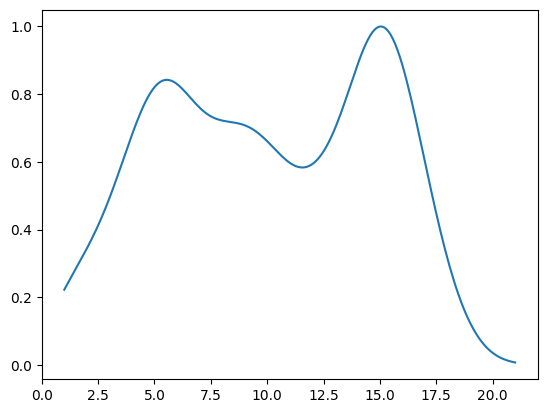

In [200]:
%matplotlib inline
smoothhist([len(t) for t in the_neighby_node_of_the_rect])

In [16]:
grid_poses = LaLotudeVector
grid_list= []
for grid_pos in tqdm(grid_poses):
    grid_list.append(np.where(np.logical_and(
                    (node2position < (grid_pos + unit)).all(axis=1),
                    (node2position > (grid_pos - unit)).all(axis=1)))
                    )

  8%|▊         | 43790/519840 [01:11<12:58, 611.29it/s]


KeyboardInterrupt: 

In [205]:
from tqdm.notebook import tqdm

In [206]:
hard_indexes = []
for idx,grid_pos in tqdm(enumerate(LaLotudeVector)):
    rough_range_index = np.where(np.logical_and((node2position < (grid_pos + unit)).all(axis=1),
                                                (node2position > (grid_pos - unit)).all(axis=1)))[0]
    rough_range = node2position[rough_range_index]
    hard_index  = np.where(np.linalg.norm(rough_range - grid_pos,axis=1)<0.6*unit)
    hard_indexes.append(rough_range_index[hard_index])
    

0it [00:00, ?it/s]

In [207]:
aware =[ len(t) for t in hard_indexes]

In [208]:
from mltool.visualization import *